In [1]:
# import libraries
import os
import pandas as pd
import folium
from folium.plugins import HeatMap
from folium import plugins
import branca
import branca.colormap as bcm 
import json
import requests
import geopandas
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Data pre-processing

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'

crashes_df = pd.read_csv("Crashes_Last_Five_Years.csv")
bay_sensors_df = pd.read_csv("On-street_Parking_Bay_Sensors.csv")
country_df = pd.read_csv(county_data, na_values=[' '])

# Load the unemployment value of each state
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
state_data = pd.read_csv('US_Unemployment_Oct2012.csv')

def df_to_list(path_df, col_latitude, col_longitude):
    """
    A convient function to transform dataframe of locations into list of lists for the path map;
    path_df: a dataframe contains the locations
    col_latitude: column name of latitude
    col_longitude: column name of longitude
    """

    location_list =[] 
    # iterate over the rows
    for _, rows in path_df[[col_latitude, col_longitude]].iterrows(): 
        temp_list =[rows[col_latitude], rows[col_longitude]] 

        # append the list to the final list 
        location_list.append(temp_list) 
    return location_list

park_location = df_to_list(bay_sensors_df, 'lat', 'lon')
crashes_list = [[row['Y'],row['X']] for index, row in crashes_df[(crashes_df['LGA_NAME_ALL'].str.contains("MORNINGTON"))].iterrows()]
employed_series = country_df.set_index('FIPS_Code')['Employed_2011']

# Folium 
## Heatmap
### Parameters:	
data (list of points of the form [lat, lng] or [lat, lng, weight]) - The points you want to plot. 
> You can also provide a numpy.array of shape (n,2) or (n,3).

name (string, default None) - The name of the Layer, as it will appear in LayerControls.

min_opacity (default 1.) - The minimum opacity the heat will start at.

max_zoom (default 18) - Zoom level where the points reach maximum intensity (as intensity scales with zoom), equals maxZoom of the map by default

max_val (float, default 1.) - Maximum point intensity

radius (int, default 25) - Radius of each “point” of the heatmap

blur (int, default 15) - Amount of blur

gradient (dict, default None) - Color gradient config. 
> e.g. {0.4: ‘blue’, 0.65: ‘lime’, 1: ‘red’}

overlay (bool, default True) - Adds the layer as an optional overlay (True) or the base layer (False).

control (bool, default True) - Whether the Layer will be included in LayerControls.

show (bool, default True) - Whether the layer will be shown on opening (only for overlays).

### render(**kwargs)
* Renders the HTML representation of the element.	

In [3]:
# create the heatmap
# tiles:
# “OpenStreetMap”
# “Mapbox Bright” (Limited levels of zoom for free tiles)
# “Mapbox Control Room” (Limited levels of zoom for free tiles)
# “Stamen” (Terrain, Toner, and Watercolor)
# “Cloudmade” (Must pass API key)
# “Mapbox” (Must pass API key)
# “CartoDB” (positron and dark_matter)
# The default tiles are set to OpenStreetMap, but Stamen Terrain, Stamen Toner, Mapbox Bright, 
# and Mapbox Control Room, and many others tiles are built in.
hmap = folium.Map(location=[-38.3002,145.0827],tiles='OpenStreetMap',zoom_start=11)

# create self-defined colour map
# if you prefer to have a continuous set of colors. This can be done by LinearColormap.
# linear = bcm.LinearColormap(['yellow', 'red'], vmin=0, vmax=1)
# you can set the index if you want something irregular.
# linear = bcm.LinearColormap(['red', 'orange', 'yellow', 'green'],index=[0, 0.1, 0.9, 1.0])
# If you want to transform a linear map into a step one, you can use the method to_step.
# color_map = linear.to_step(n=6,data=[30.6, 50, 51, 52, 53, 54, 55, 60, 70, 100],method='quantiles',round_method='int')
# For convenience, there is a (small) set of built-in linear colormaps, in folium.colormap.linear.
# if you want to check them all, simply ask for `.linear` in the notebook.
steps = 6
color_map = bcm.linear.OrRd_05.scale(0, 1).to_step(steps)

gradient_map={}
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

hm_wide = HeatMap( crashes_list,
                   name="Crashes",
                   min_opacity=0.01,
                   max_val=8.0,
                   radius=15, blur=10, 
                   max_zoom=10, 
                   gradient=gradient_map,
                   overlay=True, control=True, show=True
                 )
hmap.add_child(color_map)
hmap.add_child(hm_wide)

# save the map to html.files
hmap.save('heatmap.html')

hmap

In [4]:
hmap_park = folium.Map(location=[-37.8210, 144.94689],tiles='OpenStreetMap',zoom_start=14)


steps_park = 5
color_map_park = bcm.linear.BrBG_04.scale(0, 1).to_step(steps_park)
color_map_park.caption = 'On-street_Parking_Bay_Sensors'

gradient_map_park ={}
for i in range(steps_park):
    gradient_map_park[1/steps_park*i] = color_map_park.rgb_hex_str(1/steps_park*i)
    
hm_park = HeatMap( park_location,
                   name="Crashes",
                   min_opacity=0.5,
                   max_val=8.0,
                   radius=10, blur=10, 
                   max_zoom=8, 
                   gradient=gradient_map_park,
                   overlay=True, control=True, show=True
                 )
hmap_park.add_child(color_map_park)
hmap_park.add_child(hm_park)

# save the map to html.files
hmap_park.save('heatmap_park.html')

hmap_park

## PolyLine
locations (list of points (latitude, longitude)) 
> Latitude and Longitude of line (Northing, Easting)

popup (str or folium.Popup, default None) 
> Input text or visualization for object displayed when clicking.

tooltip (str or folium.Tooltip, default None) 
> Display a text when hovering over the object.

smooth_factor (float, default 1.0) 
> How much to simplify the polyline on each zoom level. More means better performance and smoother look, and less means more accurate representation.

no_clip (Bool, default False) 
> Disable polyline clipping.

**kwargs 
> Other valid (possibly inherited) options. See: https://leafletjs.com/reference-1.5.1.html#polyline

In [5]:
#  -38.3002,145.0827
park_path_map = folium.Map(location=[-37.8210, 144.94689],tiles='OpenStreetMap',zoom_start=14) 

# color_options 
# {'beige', 'black', 'blue', 'cadetblue', 'darkblue', 'darkgreen', 
# 'darkpurple', 'darkred', 'gray', 'green', 'lightblue', 'lightgray', 
# 'lightgreen', 'lightred', 'orange', 'pink', 'purple', 'red', 'white'}

#add lines
folium.PolyLine(sorted(park_location[:5]), 
                       weight=9, color="cadetblue",
                       popup=None, tooltip=None,
                       opacity=1).add_to(park_path_map)

folium.PolyLine(sorted(park_location[10:16]), 
                weight=6, color='darkred', 
                popup=None, tooltip=None, 
                opacity=1).add_to(park_path_map)

# save the map to html.files
park_path_map.save('park_path_map.html')

park_path_map

## Marker
### Parameters
location (tuple or list)
> Latitude and Longitude of Marker (Northing, Easting)

popup (string or folium.Popup, default None)
> Label for the Marker; either an escaped HTML string to initialize folium.Popup or a folium.Popup instance.

tooltip (str or folium.Tooltip, default None)
> Display a text when hovering over the object.

icon (Icon plugin)
> the Icon plugin to use to render the marker.

draggable (bool, default False)
> Set to True to be able to drag the marker around the map.

### Returns
Return type
> Marker names and HTML in obj.template_vars

In [6]:
# icon: 'ok-sign', 'remove-sign' 
# More icon: https://getbootstrap.com/docs/3.3/components/#glyphicons-glyphs

folium.Marker(
    location=park_location[0],
    popup='Remove',
    icon=folium.Icon(color='red', icon='glyphicon glyphicon-remove'),
).add_to(park_path_map)

folium.Marker(
    location=park_location[1],
    popup='Ok',
    icon=folium.Icon(color='blue', icon='glyphicon glyphicon-ok'),
).add_to(park_path_map)

# save the map to html.files
park_path_map.save('park_path_map.html')

park_path_map

In [7]:
example_map = folium.Map(location=[-38.3002,145.0827], tiles='OpenStreetMap', zoom_start=11)

# to add the legend
legend_html =   '''
                    <div style="position: fixed; 
                                bottom: 400px; left: 120px; width: 100px; height: 90px; 
                                border:2px solid black; z-index:9999; font-size:14px;
                                ">&nbsp; Line Legend <br>
                                  &nbsp; First 5 &nbsp; <i class="glyphicon glyphicon-minus" style="color:orange"></i><br>
                                  &nbsp; 10 to 16 &nbsp; <i class="glyphicon glyphicon-minus" style="color:darkblue"></i>
                    </div>
                ''' 
folium.PolyLine(sorted(crashes_list[:5]), 
                weight=5, color='orange', 
                popup=None, tooltip=None, 
                opacity=1).add_to(example_map)

folium.PolyLine(sorted(crashes_list[10:16]), 
                weight=5, color='darkblue', 
                popup=None, tooltip=None, 
                opacity=0.5).add_to(example_map)

folium.Marker(
    location=crashes_list[0],
    popup='No.',
    icon=folium.Icon(color='red', icon='glyphicon glyphicon-remove'),
).add_to(example_map)

folium.Marker(
    location=crashes_list[1],
    popup='Ok.',
    icon=folium.Icon(color='green', icon='ok-sign'),
).add_to(example_map)
example_map.get_root().html.add_child(folium.Element(legend_html))
example_map.save('example_map.html')
example_map

## GeoJson
### Parameters
data (file, dict or str.) - The GeoJSON data you want to plot. 
> * If file, then data will be read in the file and fully embedded in Leaflet’s JavaScript. 
> * If dict, then data will be converted to JSON and embedded in the JavaScript. 
> * If str, then data will be passed to the JavaScript as-is.

style_function (function, default None) - Function mapping a GeoJson Feature to a style dict.

highlight_function (function, default None) - Function mapping a GeoJson Feature to a style dict for mouse events.

name (string, default None) - The name of the Layer, as it will appear in LayerControls

overlay (bool, default True) - Adds the layer as an optional overlay (True) or the base layer (False).

control (bool, default True) - Whether the Layer will be included in LayerControls

show (bool, default True) - Whether the layer will be shown on opening (only for overlays).

smooth_factor (float, default None) - How much to simplify the polyline on each zoom level. 
> More means better performance and smoother look, and less means more accurate representation. Leaflet defaults to 1.0.

tooltip (GeoJsonTooltip, Tooltip or str, default None) - Display a text when hovering over the object. 
> Can utilize the data, see folium.GeoJsonTooltip for info on how to do that.

embed (bool, default True) - Whether to embed the data in the html file or not. 
> Note that disabling embedding is only supported if you provide a file link or URL.

In [53]:
# Path configuration
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
us_states = f'{url}/us-states.json'
US_Unemployment_Oct2012 = f'{url}/US_Unemployment_Oct2012.csv'

# Prepare data
unemployment = pd.read_csv(US_Unemployment_Oct2012)
unemployment_dict = unemployment.set_index('State')['Unemployment']

geo_json_data = json.loads(requests.get(us_states).text)

# Create map
geo_map = folium.Map([43, -100], zoom_start=4)
# Set Color bar
colormap = bcm.linear.YlGn_09.scale(
    unemployment.Unemployment.min(),
    unemployment.Unemployment.max())
# Add color legend
colormap.caption = 'US_Unemployment_Oct2012'
geo_map.add_child(colormap)
# Creates a GeoJson object for plotting into a Map
folium.GeoJson(
    geo_json_data,
    name='unemployment',
    # Provide a style_function that color the map
    style_function=lambda feature: {
        #'fillColor': 'green' if 'e' in feature['properties']['name'].lower() else '#ffff00',
        'fillColor': colormap(unemployment_dict[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(geo_map)


geo_map.save('GeoJSON.html')

geo_map

## TopoJson
### Parameters
data (file, dict or str.) – The TopoJSON data you want to plot. 
> * If file, then data will be read in the file and fully embedded in Leaflet’s JavaScript. 
> * If dict, then data will be converted to JSON and embedded in the JavaScript. 
> * If str, then data will be passed to the JavaScript as-is.

object_path (str) – The path of the desired object into the TopoJson structure. 
> Ex: ‘objects.myobject’.

style_function (function, default None) – A function mapping a TopoJson geometry to a style dict.

name (string, default None) – The name of the Layer, as it will appear in LayerControls

overlay (bool, default False) – Adds the layer as an optional overlay (True) or the base layer (False).

control (bool, default True) – Whether the Layer will be included in LayerControls.

show (bool, default True) – Whether the layer will be shown on opening (only for overlays).

smooth_factor (float, default None) – How much to simplify the polyline on each zoom level. 
> More means better performance and smoother look, and less means more accurate representation. Leaflet defaults to 1.0.

tooltip (GeoJsonTooltip, Tooltip or str, default None) – Display a text when hovering over the object. 
> Can utilize the data, see folium.GeoJsonTooltip for info on how to do that.

In [54]:
# Path configuration
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'

# Prepare data
topo_df = pd.read_csv(county_data, na_values=[' '])
employed_series = topo_df.set_index('FIPS_Code')['Employed_2011']
# Set Color bar
colorscale = bcm.linear.YlOrRd_09.scale(0, 50e3)
# Add color legend
colorscale.caption = 'us_counties_20m_topo'
topo_map.add_child(colorscale)

# Provide a style_function that color the map.
def style_function(feature):
    employed = employed_series.get(int(feature['id'][-5:]), None)
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black' if employed is None else colorscale(employed)
    }
# Create map
topo_map = folium.Map(location=[48, -102], tiles='cartodbpositron', zoom_start=3.4)
# Creates a TopoJson object for plotting into a Map.
folium.TopoJson(json.loads(requests.get(county_geo).text),
                'objects.us_counties_20m',
                style_function = style_function
               ).add_to(topo_map)
# Add color legend
topo_map.add_child(colorscale)
topo_map

## Choropleth
### Parameters
* geo_data (string/object) – URL, file path, or data (json, dict, geopandas, etc) to your GeoJSON geometries
* data (Pandas DataFrame or Series, default None) – Data to bind to the GeoJSON.
* columns (dict or tuple, default None) – If the data is a Pandas DataFrame, the columns of data to be bound. 
> Must pass column 1 as the key, and column 2 the values.
* key_on (string, default None) – Variable in the geo_data GeoJSON file to bind the data to. 
> Must start with ‘feature’ and be in JavaScript objection notation. Ex: ‘feature.id’ or ‘feature.properties.statename’.
* bins (int or sequence of scalars or str, default 6)
> If bins is an int, it defines the number of equal-width bins between the min and the max of the values. If bins is a sequence, it directly defines the bin edges. For more information on this parameter, have a look at numpy.histogram function.
* fill_color (string, default 'blue') – Area fill color. 
> Can pass a hex code, color name, or if you are binding data, one of the following color brewer palettes: ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
* nan_fill_color (string, default 'black') – Area fill color for nan or missing values. 
> Can pass a hex code, color name.

* fill_opacity (float, default 0.6) – Area fill opacity, range 0-1.
* nan_fill_opacity (float, default fill_opacity) – Area fill opacity for nan or missing values, range 0-1.
* line_color (string, default 'black') – GeoJSON geopath line color.
* line_weight (int, default 1) – GeoJSON geopath line weight.
* line_opacity (float, default 1) – GeoJSON geopath line opacity, range 0-1.
* legend_name (string, default empty string) – Title for data legend.
* topojson (string, default None) 
> If using a TopoJSON, passing “objects.yourfeature” to the topojson keyword argument will enable conversion to GeoJSON.
* smooth_factor (float, default None) – How much to simplify the polyline on each zoom level. 
> More means better performance and smoother look, and less means more accurate representation. Leaflet defaults to 1.0.
* highlight (boolean, default False) – Enable highlight functionality when hovering over a GeoJSON area.
* name (string, optional) – The name of the layer, as it will appear in LayerControls
* overlay (bool, default False) – Adds the layer as an optional overlay (True) or the base layer (False).
* control (bool, default True) – Whether the Layer will be included in LayerControls.
* show (bool, default True) – Whether the layer will be shown on opening (only for overlays).

### Returns
* Return type - GeoJSON data layer in obj.template_vars

## LayerControl
### Parameters
position (str) – The position of the control (one of the map corners)
> can be ‘topleft’, ‘topright’, ‘bottomleft’ or ‘bottomright’ default: ‘topright’

collapsed (bool, default True)
> If true the control will be collapsed into an icon and expanded on mouse hover or touch.

autoZIndex (bool, default True)
> If true the control assigns zIndexes in increasing order to all of its layers so that the order is preserved when switching them on/off.

**kwargs – Additional (possibly inherited) options. See https://leafletjs.com/reference-1.5.1.html#control-layers
### render(**kwargs)
Renders the HTML representation of the element.

In [72]:
# Prepare data
messed_up_data = unemployment.drop(0)
messed_up_data.loc[4, 'Unemployment'] = float('nan')
# Create map
choro_map = folium.Map([43, -100], zoom_start=4)
# Render the GeoJson/TopoJson and color scale objects.
choropleth = folium.Choropleth(
    geo_data=us_states,
    data=messed_up_data,
    columns=['State', 'Unemployment'],
    bins=[3, 5, 8, 11],
    key_on='feature.id',
    nan_fill_color='orange',
    nan_fill_opacity=0.4,
    fill_opacity=0.7,
    line_opacity=0.2,
    fill_color='YlGn',
    name='Unenployment',
    legend_name='Unemployment Rate (%)',
    highlight=True,
    show=False,
).add_to(choro_map)

# Creates a LayerControl object to be added on a folium map.
# This object should be added to a Map object. 
# Only Layer children of Map are included in the layer control.
#folium.LayerControl(collapsed=False).add_to(choro_map)
folium.LayerControl().add_to(choro_map)
choro_map.save('choropleth.html')

choro_map

# Other libs

In [73]:
import geopandas
# Create geodf from df
gdf = geopandas.GeoDataFrame(
    crashes_df, geometry=geopandas.points_from_xy(crashes_df.X, crashes_df.Y))
gdf.crs = {'init': 'epsg:4326', 'no_defs': True}

<Figure size 1600x1200 with 0 Axes>

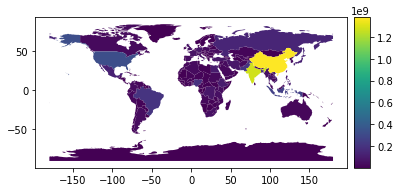

In [74]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# setting plot size
plt.figure(figsize=(16,12), dpi= 100)

fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(column='pop_est', ax=ax, legend=True, cax=cax)

plt.show()

In [77]:
import geoplotlib
from geoplotlib.utils import read_csv, BoundingBox, DataAccessObject

data = read_csv('opencellid_dk.csv')

#geoplotlib.kde(data, bw=5, cut_below=1e-4)

# lowering clip_above changes the max value in the color scale
#geoplotlib.kde(data, bw=5, cut_below=1e-4, clip_above=.1)

# different bandwidths
#geoplotlib.kde(data, bw=20, cmap='PuBuGn', cut_below=1e-4)
#geoplotlib.kde(data, bw=2, cmap='PuBuGn', cut_below=1e-4)

# linear colorscale
geoplotlib.kde(data, bw=5, cmap='jet', cut_below=1e-4, scaling='lin')

geoplotlib.set_bbox(BoundingBox.KBH)
geoplotlib.show()

('smallest non-zero count', 4.9751871438797864e-05)
('max count:', 0.7072370569867709)
